In [1]:
import pandas as pd
import datetime as dt

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"

In [2]:
data = pd.read_csv("Data/Edu_TS_all.csv", sep=";", index_col=0,
                   parse_dates=True)
data.plot().update_layout(height=350, width=1350).show()

In [30]:
pd.DataFrame(data['Paid Orders'])

,Paid Orders
Date,
01.05.2023,588
02.05.2023,532
03.05.2023,599
04.05.2023,559
05.05.2023,480
...,...
18.10.2023,1058
19.10.2023,1065
20.10.2023,1060


In [4]:
data.describe()

,Paid Orders,Trial Orders,Unique Visitors,Paid Carts Visitors,Trial Carts Visitors
count,175.000000,175.000000,175.000000,175.000000,175.000000
mean,911.542857,391.274286,44078.474286,846.468571,835.080000
std,187.120796,201.796797,5591.656350,211.907315,376.223131
min,424.000000,171.000000,29943.000000,319.000000,0.000000
25%,817.000000,276.500000,40831.000000,761.500000,570.500000
50%,925.000000,330.000000,44351.000000,865.000000,841.000000
75%,1044.500000,389.000000,47451.000000,959.000000,1078.000000
max,1281.000000,1015.000000,56456.000000,1526.000000,1687.000000


Разберём графики более подробно. Начнём с графиков заказов

In [6]:
fig = px.line(data, y=["Paid Orders", "Trial Orders"])

fig.update_layout(height=350, width=1350, title='Orders')

Теперь рассмотрим посетителей на корзинах

In [7]:
fig = px.line(data, y=["Paid Carts Visitors", "Trial Carts Visitors"])

fig.update_layout(height=350, width=1350, title='Orders')

## Стационарность временного ряда

Некоторые методы машинного обучения, такие как ARIMA, используют в качестве исходных данных стационарные временные ряды. Не должно быть структуры, зависящей от времени, например сезонности, которая может вызвать проблемы с предположениями модели прогнозирования.
Это можно проверить статистически с помощью теста Augmented Dickey-Fuller в statsmodels. Значение p <= 0,05 говорит о том, что временной ряд является стационарным, а значение > 0,05 говорит о том, что может быть какая-то зависимая от времени связь, на которую нужно обратить внимание перед прогнозированием.

In [12]:
from statsmodels.tsa.stattools import adfuller

for column in data.columns:
    adf_result = adfuller(data[column])

    # Parse test statistic and p value
    print(f'ADF Test Statistic {adf_result[0]:.2f} for {column}')
    print(f'P Value {adf_result[1]:.2f} for {column}')
    if adf_result[1] > 0.05:
        print(f'{column} is not stationary. Time-dependent structure such as seasonality exists. \n -------------')
    else:
        print(f'{column} is stationary, p value < 0.05. \n -------------')

ADF Test Statistic -2.24 for Paid Orders
P Value 0.19 for Paid Orders
Paid Orders is not stationary. Time-dependent structure such as seasonality exists. 
 -------------
ADF Test Statistic -2.92 for Trial Orders
P Value 0.04 for Trial Orders
Trial Orders is stationary, p value < 0.05. 
 -------------
ADF Test Statistic -1.09 for Unique Visitors
P Value 0.72 for Unique Visitors
Unique Visitors is not stationary. Time-dependent structure such as seasonality exists. 
 -------------
ADF Test Statistic -2.16 for Paid Carts Visitors
P Value 0.22 for Paid Carts Visitors
Paid Carts Visitors is not stationary. Time-dependent structure such as seasonality exists. 
 -------------
ADF Test Statistic 0.28 for Trial Carts Visitors
P Value 0.98 for Trial Carts Visitors
Trial Carts Visitors is not stationary. Time-dependent structure such as seasonality exists. 
 -------------


Среди всех временных рядов только "Trial Orders" стационарен, давайте его рассмотрим подробнее

TypeError: cannot unpack non-iterable Figure object

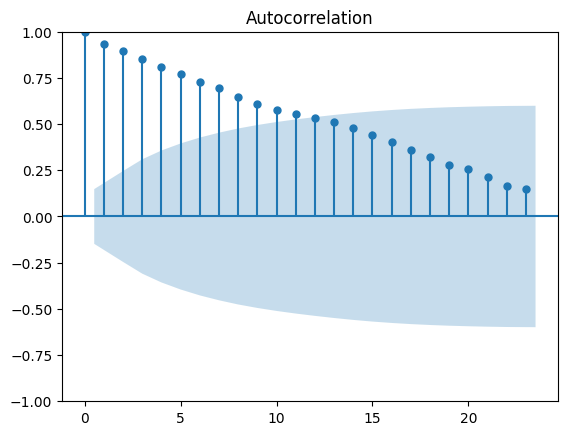

In [25]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

acf_values, confint = plot_acf(data['Trial Orders'], alpha=0.05)

# Create a Plotly figure
fig = go.Figure([
    go.Bar(x=np.arange(len(acf_values)), y=acf_values, name='ACF'),
    go.Scatter(x=np.arange(len(acf_values)), y=confint[:, 0], fill=None, mode='lines', line=dict(color='blue'), name='95% CI (Lower)'),
    go.Scatter(x=np.arange(len(acf_values)), y=confint[:, 1], fill='tonexty', mode='lines', line=dict(color='blue'), name='95% CI (Upper)')
])

# Update layout
fig.update_layout(
    title='Autocorrelation Plot (ACF)',
    xaxis_title='Lag',
    yaxis_title='Autocorrelation',
    height=350,
    width=1350
)

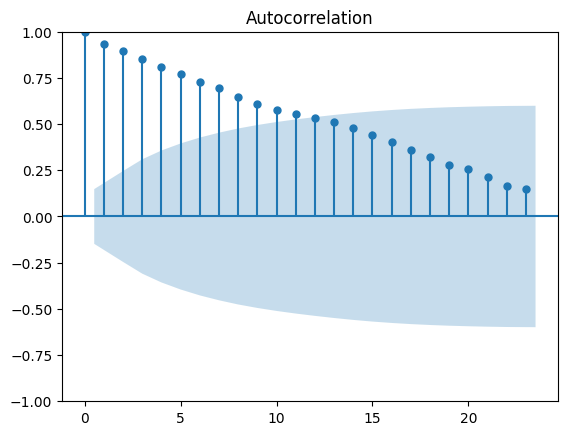

In [23]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

# Plot ACF using Matplotlib
plot_acf(data["Trial Orders"], alpha=0.05, ax=ax)

plotly_fig = go.Figure()
plotly_fig = go.Figure(go.Scatter(
    x=ax.lines[0].get_xdata(),
    y=ax.lines[0].get_ydata(),
    mode='lines',
    name='Autocorrelation'
))

# Convert the Matplotlib plot to Plotly
plotly_fig.update_layout(title='Autocorrelation Plot (ACF) for Trial Orders', xaxis_title='Lag', yaxis_title='Autocorrelation')
plotly_fig.show()

## Average Order Value

In [14]:
aov_paid = pd.read_csv('Data/Edu_TS_4_Aov.csv', index_col=0)
aov_paid

,Date,Revenue,Orders,AOV,Product_id
0,2023-05-01,0.000,42,0.000000,NaN
1,2023-05-01,0.000,0,NaN,1.0
2,2023-05-01,0.000,0,NaN,2.0
3,2023-05-01,64.554,6,10.759000,9.0
4,2023-05-01,1109.654,39,28.452667,10.0
...,...,...,...,...,...
2785,2023-10-22,0.000,0,NaN,8.0
2786,2023-10-22,21.924,4,5.481000,14.0
2787,2023-10-22,0.000,0,NaN,15.0
2788,2023-10-22,205.366,148,1.387608,16.0


In [15]:
aov_paid['Date'] = pd.to_datetime(aov_paid['Date'], format='%Y-%m-%d')

In [16]:
df = pd.pivot_table(data=aov_paid, values='AOV',
               index='Date', aggfunc="sum")
df = df.reset_index()
df.Date = pd.to_datetime(df.Date)

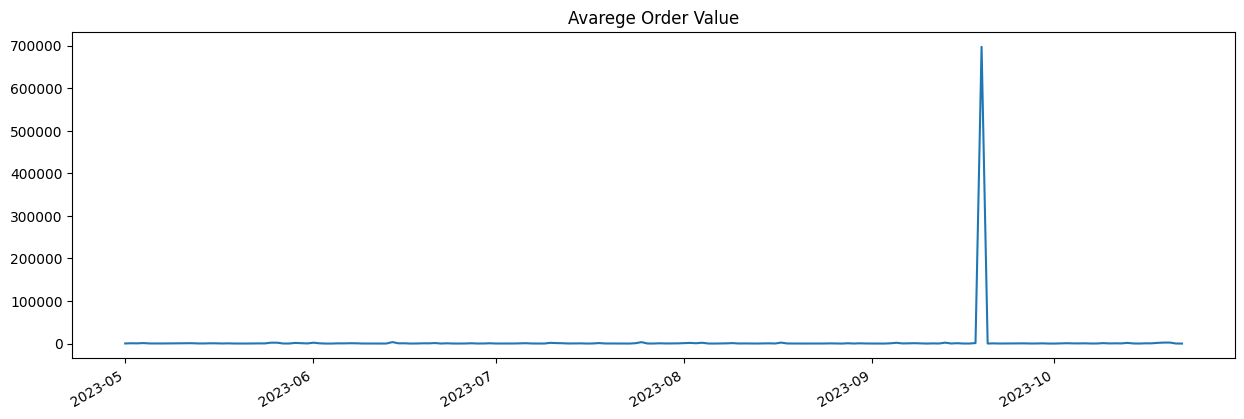

In [17]:
plt.figure().set_figwidth(15)
plt.title(label='Avarege Order Value')
plt.plot(df.Date, df.AOV)
plt.gcf().autofmt_xdate()

plt.show()